In [1]:
#import modules and renew token
from __future__ import print_function
import sys
import spotipy
import spotipy.util as util
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
%matplotlib inline

username = "your user id"
client_id ="your client id" 
client_secret = "your client secret"
redirect_uri = 'http://localhost:7777/callback'
scope = 'user-library-read playlist-read-private'# playlist-read-private  playlist-modify-public'

token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri=redirect_uri)

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope, 
                                        client_id=client_id,   
                                        client_secret=client_secret,     
                                        redirect_uri=redirect_uri,
                                          show_dialog=True))

token
sp.me()

NameError: name 'SpotifyOAuth' is not defined

In [2]:
#get 50 songs from user saved library, each song has features describing its attributes
def get_songs(songoffset):
    tracknames = []
    ids = []
    dateadded = []

    if token:
        sp = spotipy.Spotify(auth=token)
        results = sp.current_user_saved_tracks(limit=50, offset = songoffset)
        playlists = sp.current_user_playlists(limit=50, offset=0)
        for item in results['items']:
            track = item['track']['name']
            trackid = item['track']['id']
            addedat = item['added_at']
            #print(trackid)
            #print(track['name'] + ' - ' + track['artists'][0]['name'])

            tracknames.append(track)
            #trackid = get_id(track['name'],token)
            ids.append(trackid)
            dateadded.append(addedat)
            #features = get_features(trackid, token)
            #trackfeatures.append(features)
    else:
        print("Can't get token for", username)
    features = sp.audio_features(ids) 
    df = pd.DataFrame(features)
    trackdesc = df.describe()
    mean = trackdesc.iloc[1]
    dfpca = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence','tempo','duration_ms','time_signature']]
    
    tracknames = pd.DataFrame(tracknames,columns=['song_name'])
    dateadded = pd.DataFrame(dateadded,columns=['date_added'])
    df = pd.concat([df,tracknames,dateadded], axis = 1)
    
    return df

In [3]:
#get songs in multiples of 50, repeat for both users
#get songs in multiples of 50
start = 0
df = get_songs(start)
for i in range(start+1,start+9):
    offset = i*50
    dfcurrent = get_songs(offset)
    print(offset)
    df = pd.concat([df,dfcurrent])
    i += 1
df = df.reset_index(drop=True)
df['Label'] = 0
df0 = df

#get songs in multiples of 50
start = 70
df = get_songs(start)
for i in range(start+1,start+9):
    offset = i*50
    dfcurrent = get_songs(offset)
    print(offset)
    df = pd.concat([df,dfcurrent])
    i += 1
df = df.reset_index(drop=True)
df['Label'] = 1
df1 = df

50
100
150
200
250
300
350
400
3550
3600
3650
3700
3750
3800
3850
3900


              precision    recall  f1-score   support

           0       0.68      0.65      0.67       450
           1       0.67      0.69      0.68       450

    accuracy                           0.67       900
   macro avg       0.67      0.67      0.67       900
weighted avg       0.67      0.67      0.67       900



<AxesSubplot:xlabel='None'>

<Figure size 576x576 with 0 Axes>

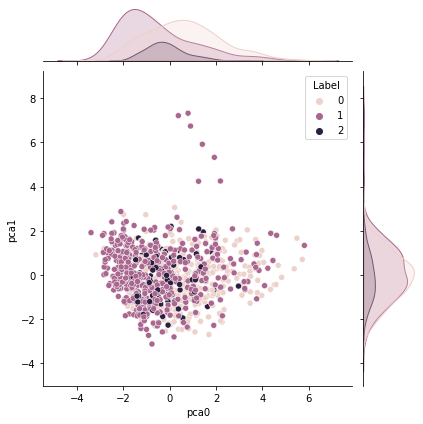

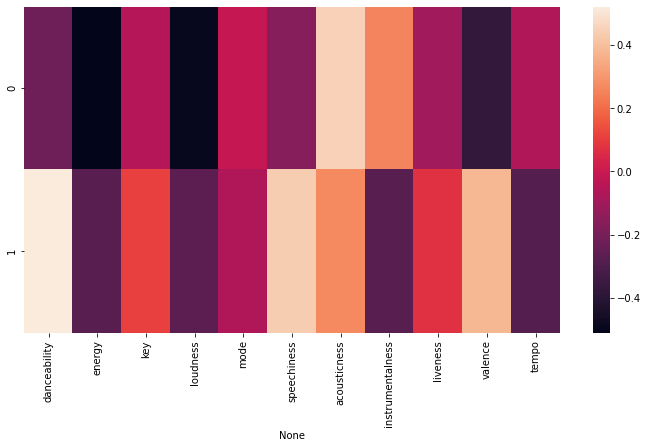

In [11]:
#create model for classifying songs for each user
#create list of songs which model has lowest confidence in classifying, represents the songs users tastes have in common
dfall = pd.concat([df0, df1]).reset_index(drop=True)
numsongs = len(dfall)

dfall = dfall.reset_index(drop=True)

X = dfall[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence','tempo']]

#scale features as they have very different ranges
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

from sklearn.model_selection import train_test_split

y = dfall['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#fit on everything using linear model
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X,y)

predictions = logmodel.predict(X)
predictionsproba = logmodel.predict_proba(X)
from sklearn.metrics import classification_report
print(classification_report(y,predictions))

##pick songs model is most unsure of, probability of classification closest to 0.5
plusminus = 0
playlistlength = 90 #not over 95
sharedliked = []
while len(sharedliked) < playlistlength:
    sharedliked = []
    plusminus += .0001
    for predict in enumerate(predictionsproba):
        if .50-plusminus < predict[1][0] < .50+plusminus:
            sharedliked.append(predict[0])
    #print(len(sharedliked))
sharedliked
sharedlikedsongs = dfall.iloc[sharedliked]

from sklearn.utils import shuffle
sharedlikedsongsshuffled = shuffle(sharedlikedsongs).reset_index(drop=True)

len(sharedliked)

#change label of selected "shared" songs to 2 to indicated shared
dfallmod = dfall
dfallmod.loc[sharedliked,'Label'] = 2

#dfboth = pd.concat([dfJack,dfAmy]).reset_index(drop=True)

dfallfeatures = dfall[['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo']]

scaler = StandardScaler()
scaler.fit(dfallfeatures)
dfscaled = scaler.transform(dfallfeatures)
dfscaled = pd.DataFrame(dfscaled,columns=dfallfeatures.columns)

## run PCA analysis to plot higher dimensional features in 2D
pca = PCA(n_components=2)
pca.fit(dfscaled)
x_pca = pca.transform(dfscaled)
dfx_pca = pd.DataFrame(x_pca,columns=['pca0','pca1'])
dfx_pca['Label'] = dfall['Label']
dfx_pca['index'] = dfall.index

# fig = plt.figure()
# plt.fig(figsize=(15,15))
# ax1 = fig.add_subplot(111)
plt.figure(figsize=(8, 8))
#sns.scatterplot(data=dfx_pca, x='pca0', y="pca1",hue='Label',size="index")
sns.jointplot(data=dfx_pca, x='pca0', y="pca1",hue='Label',cmap='plasma')

pca.components_
df_comp = pd.DataFrame(pca.components_,columns=[dfscaled.columns])
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,)
# print(df_comp.iloc[0].abs().sort_values(ascending=False))
# print(df_comp.iloc[1].abs().sort_values(ascending=False))
# dfx_pca

In [12]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
normalizer = preprocessing.Normalization()
from sklearn.model_selection import train_test_split

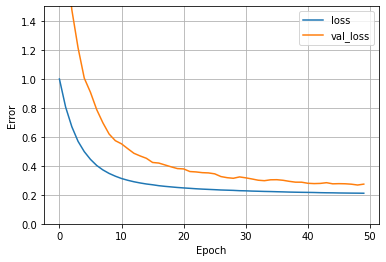

In [13]:
##This time create model using basic neural network to classify each users music taste
dfall = pd.concat([df0, df1]).reset_index(drop=True)
numsongs = len(dfall)

X = dfall[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence','tempo']]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

from sklearn.model_selection import train_test_split

y = dfall['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = keras.Sequential()

model.add(Dense(8, activation='relu'))
#model.add(Dense(64, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss='mean_squared_error')
#history = model.fit(X_train,y_train,validation_split=0.2,verbose=0,epochs=50,batch_size = 100)
#%%time

history = model.fit(
    X, y,
    validation_split=0.1,
    verbose=0, epochs=50)

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1.5])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

              precision    recall  f1-score   support

           0       0.62      0.78      0.69       450
           1       0.70      0.53      0.61       450

    accuracy                           0.65       900
   macro avg       0.66      0.65      0.65       900
weighted avg       0.66      0.65      0.65       900

90


<AxesSubplot:xlabel='None'>

<Figure size 576x576 with 0 Axes>

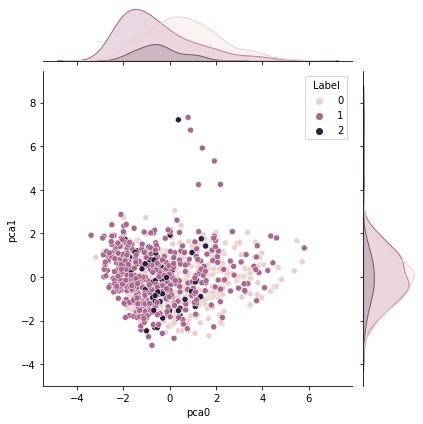

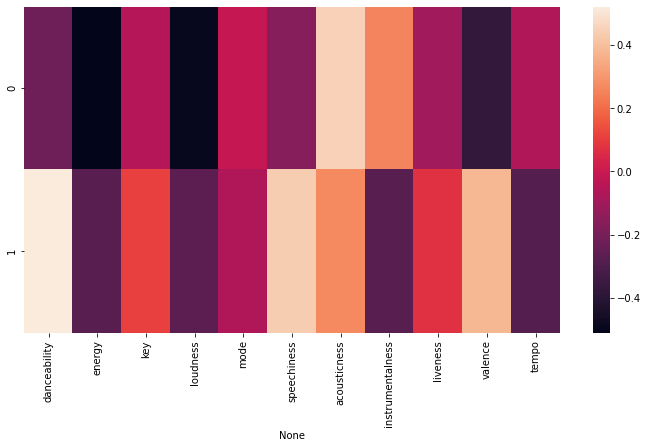

In [14]:
predictions = model.predict(X)
# predictionsproba = model.predict_proba(X)
# predictionsproba

##again choose songs model is most unsure of, prediction probability near 0.5
from sklearn.metrics import classification_report
print(classification_report(y,np.round(predictions)))
plusminus = 0
playlistlength = 90 #not over 95
sharedliked = []
while len(sharedliked) < playlistlength:
    sharedliked = []
    plusminus += .0001
    for predict in enumerate(predictions):
        if .50-plusminus < predict[1][0] < .50+plusminus:
            sharedliked.append(predict[0])
    #print(len(sharedliked))
sharedliked
sharedlikedsongs = dfall.iloc[sharedliked]

from sklearn.utils import shuffle
sharedlikedsongsshuffled = shuffle(sharedlikedsongs).reset_index(drop=True)

print(len(sharedliked))

dfallmod = dfall
dfallmod.loc[sharedliked,'Label'] = 2

#dfboth = pd.concat([dfJack,dfAmy]).reset_index(drop=True)

dfallfeatures = dfall[['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo']]

scaler = StandardScaler()
scaler.fit(dfallfeatures)
dfscaled = scaler.transform(dfallfeatures)
dfscaled = pd.DataFrame(dfscaled,columns=dfallfeatures.columns)

pca = PCA(n_components=2)
pca.fit(dfscaled)
x_pca = pca.transform(dfscaled)
dfx_pca = pd.DataFrame(x_pca,columns=['pca0','pca1'])
dfx_pca['Label'] = dfall['Label']
dfx_pca['index'] = dfall.index

# fig = plt.figure()
# plt.fig(figsize=(15,15))
# ax1 = fig.add_subplot(111)
plt.figure(figsize=(8, 8))
#sns.scatterplot(data=dfx_pca, x='pca0', y="pca1",hue='Label',size="index")
sns.jointplot(data=dfx_pca, x='pca0', y="pca1",hue='Label',cmap='plasma')

pca.components_
df_comp = pd.DataFrame(pca.components_,columns=[dfscaled.columns])
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,)
# print(df_comp.iloc[0].abs().sort_values(ascending=False))
# print(df_comp.iloc[1].abs().sort_values(ascending=False))
# dfx_pca

pca0     1.238515e-16
pca1    -6.315935e-17
Label    5.000000e-01
index    4.495000e+02
dtype: float64
90


<AxesSubplot:xlabel='None'>

<Figure size 576x576 with 0 Axes>

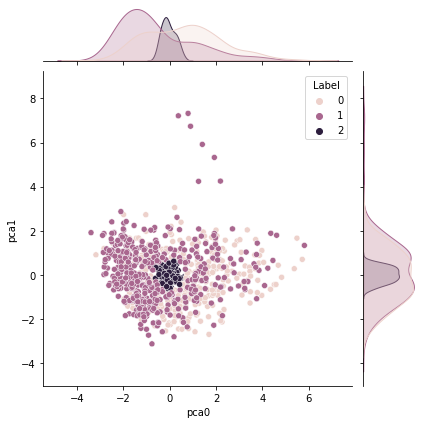

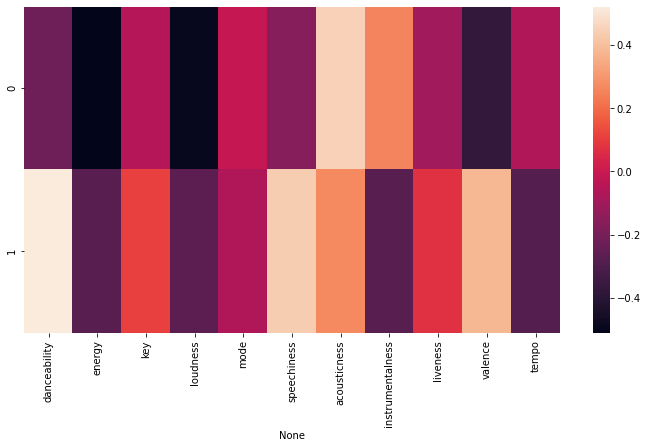

In [17]:
dfall = pd.concat([df0, df1]).reset_index(drop=True)

dfallfeatures = dfall[['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo']]

scaler = StandardScaler()
scaler.fit(dfallfeatures)
dfscaled = scaler.transform(dfallfeatures)
dfscaled = pd.DataFrame(dfscaled,columns=dfallfeatures.columns)

## Use PCA analysis to select songs in common. Reduce higher dimensional data into 2D, then select points nearest center.
##this should represent the songs with the most overlap
pca = PCA(n_components=2)
pca.fit(dfscaled)
x_pca = pca.transform(dfscaled)
dfx_pca = pd.DataFrame(x_pca,columns=['pca0','pca1'])
dfx_pca['Label'] = dfall['Label']
dfx_pca['index'] = dfall.index
dfx_pca.mean()

radius = 0
playlistlength = 90 #not over 95
sharedliked = []
while len(sharedliked) < playlistlength:
    sharedliked = []
    radius += .01
    for index, row in dfx_pca.iterrows():
        if (row['pca0']**2 + row['pca1']**2) < radius:
            sharedliked.append(index)

#         if .50-plusminus < predict[1][0] < .50+plusminus:
#             sharedliked.append(predict[0])
    #print(len(sharedliked))
sharedliked
sharedlikedsongs = dfall.iloc[sharedliked]

from sklearn.utils import shuffle
sharedlikedsongsshuffled = shuffle(sharedlikedsongs).reset_index(drop=True)

print(len(sharedliked))

dfallmod = dfall
dfallmod.loc[sharedliked,'Label'] = 2

#dfboth = pd.concat([dfJack,dfAmy]).reset_index(drop=True)

dfallfeatures = dfall[['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo']]

scaler = StandardScaler()
scaler.fit(dfallfeatures)
dfscaled = scaler.transform(dfallfeatures)
dfscaled = pd.DataFrame(dfscaled,columns=dfallfeatures.columns)

pca = PCA(n_components=2)
pca.fit(dfscaled)
x_pca = pca.transform(dfscaled)
dfx_pca = pd.DataFrame(x_pca,columns=['pca0','pca1'])
dfx_pca['Label'] = dfall['Label']
dfx_pca['index'] = dfall.index

# fig = plt.figure()
# plt.fig(figsize=(15,15))
# ax1 = fig.add_subplot(111)
plt.figure(figsize=(8, 8))
#sns.scatterplot(data=dfx_pca, x='pca0', y="pca1",hue='Label',size="index")
sns.jointplot(data=dfx_pca, x='pca0', y="pca1",hue='Label',cmap="Blues")

pca.components_
df_comp = pd.DataFrame(pca.components_,columns=[dfscaled.columns])
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,)
# print(df_comp.iloc[0].abs().sort_values(ascending=False))
# print(df_comp.iloc[1].abs().sort_values(ascending=False))
# dfx_pca

In [ ]:
#comparing the models the linear and neural network models seem to perform similarly, based on the distribution of the 
#points in the PCA model. 
#The PCA model for obvious reasons has the points closest to the center.
#An actual evaluation of the models would require users to make playlists and decide if they are agreeable to both

In [88]:
## Create playlist in Spotify ##
#playlist will be create using the shared songs generated by either logistic regression, neural network, or PCA analysis, 
#whichever has been run most recently

##this really will make a playlist

In [89]:
#create playlist
#add songs to playlist
playlistname = 'Common Sound'

#get playlist names
playlists = sp.current_user_playlists(limit=50, offset=0)
playlistnames = []
playlistids = []
playlistdict = {}
while playlists:
    for i, playlist in enumerate(playlists['items']):
        #print("%4d %s %s" % (i + 1 + playlists['offset'], playlist['uri'],  playlist['name']))
        playlistnames.append(playlist['name'])
        playlistids.append(playlist['uri'])
        playlistdict[playlist['name']]=playlist['uri']
    if playlists['next']:
        playlists = sp.next(playlists)
    else:
        playlists = None
testusername = sp.current_user()['id']
print(testusername)
if playlistname not in playlistnames:
    if token:
        sp = spotipy.Spotify(auth=token)
        sp.user_playlist_create(sp.current_user()['id'], name=playlistname)
#need to get playlist names again if a new playlist was created
    playlists = sp.current_user_playlists(limit=50, offset=0)
    playlistnames = []
    playlistids = []
    playlistdict = {}
    while playlists:
        for i, playlist in enumerate(playlists['items']):
            #print("%4d %s %s" % (i + 1 + playlists['offset'], playlist['uri'],  playlist['name']))
            playlistnames.append(playlist['name'])
            playlistids.append(playlist['uri'])
            playlistdict[playlist['name']]=playlist['uri']
        if playlists['next']:
            playlists = sp.next(playlists)
        else:
            playlists = None

playlistid = playlistdict[playlistname]

if token:
    sp = spotipy.Spotify(auth=token)
   # sp.user_playlist_create(sp.current_user()['id'], name=playlistname)
    sp.playlist_replace_items(playlistid, sharedlikedsongsshuffled['id'])

jehogan1223
